Complement of fourth and five courses

Now, let's see how Automatic differentiation AD allows the accurate evaluation of derivatives at machine precision, with only a small constant factor of overhead.

In its most basic description, AD relies on the fact that all numerical computations are ultimately compositions of a finite set of elementary operations for which derivatives are known.

For example, let's consider the computation of the derivative of this function, that represents a 1-layer neural network model:

$$f(x)=\dfrac{1}{1+exp(-(w^{T}x+b))}$$


First, let's write how to evaluate 
 via a sequence of primitive operations:

In [ ]:
x = ?  # This is an arbitrary point
f1 = w * x
f2 = f1 + b
f3 = -f2
f4 = 2.718281828459 ** f3
f5 = 1.0 + f4
f = 1.0/f5

he question mark indicates that 
 is a value that must be provided.

This program can compute the value of $f(x)$ and also populate program variables.

By using this sequence, we can evaluate $ \dfrac{df}{dx}$ at any $x$ by using the chain rule. This is called forward-mode differentiation.

In [5]:
import numpy as np
w=np.array([0,1,2,3])
x=np.array([-1,-1,-1,1])
np.dot(w,x)
w*x


array([ 0, -1, -2,  3])

In [7]:
def f(x,w,b):
    f1 = w * x                  #   1. \( f_1 = [w1 x1,\cdot,wn xn \)
    f2 = f1 + b                 #   2. \( f_2 = f_1 + b = w \cdot x + b \)
    f3 = -f2                    #   3. \( f_3 = -f_2 = -(w \cdot x + b) \)
    f4 = 2.718281828459 ** f3   #   4. \( f_4 = e^{f_3} = e^{-(w \cdot x + b)} \) 
    f5 = 1.0 + f4               #   5. \( f_5 = 1 + f_4 = 1 + e^{-(w \cdot x + b)} \)         
    return 1.0/f5               #   6. \( f(x, w, b) = \frac{1}{f_5} = \frac{1}{1 + e^{-(w \cdot x + b)}} \);f=1.0/f5 

def dfdx_forward(x, w, b):
    f1 = w * x
    p1 = w                            # p1 = df1/dx =w
    f2 = f1 + b
    p2 = p1 * 1.0                     # p2 = p1 * df2/df1 
    f3 = -f2
    p3 = p2 * -1.0                    # p3 = p2 * df3/df2
    f4 = 2.718281828459 ** f3
    
    p4 = p3 * 2.718281828459 ** f3    # p4 = p3 * df4/df3
    f5 = 1.0 + f4
    p5 = p4 * 1.0                     # p5 = p4 * df5/df4
    f6 = 1.0/f5
    dfx = p5 * -1.0 / f5 ** 2.0        # df/dx = p5 * df6/df5; 
    return f6, dfx                    #f=f6;  df/dx=df6/df5*df5/df4*df4/df3*df3/df2*df2/df1 *df1/dx


In [15]:
der = (f(3+0.00001, 2, 1) - f(3, 2, 1))/0.00001

print("Value of the function at (3, 2, 1): ",f(3, 2, 1))
print("df/dx Derivative (fin diff) at (3, 2, 1): ",der)
print("df/dx Derivative (aut diff) at (3, 2, 1): ",dfdx_forward(3, 2, 1)[1])

Value of the function at (3, 2, 1):  0.9990889488055992
df/dx Derivative (fin diff) at (3, 2, 1):  0.0018204242002717306
df/dx Derivative (aut diff) at (3, 2, 1):  0.0018204423602438651


Forward differentiation is efficient for functions $f:\mathbb{R}^{n}\rightarrow \mathbb{R}^{m}$ with $n < < m$ (only $O(n)$ sweeps are necessary). This is not the case of neural networks!
For cases $ n > > m$ a different technique is needed. To this end, we will rewrite the chain rule as:
$$ \dfrac{df}{dx} = \dfrac{df}{dg} \dfrac{dg}{dx}$$
to propagate derivatives backward from a given output. This is called reverse-mode differentiation. Reverse pass starts at the end (i.e. $\dfrac{df}{df}=1$)  and propagates backward to all dependencies.

In [17]:
import numpy as np
def dfdx_backward(x, w, b):
    f1 = w * x
    f2 = f1 + b
    f3 = -f2
    f4 = 2.718281828459 ** f3
    f5 = 1.0 + f4
    f = 1.0/f5
    
    pf = 1.0                           # pf = df/df
    p5 = 1.0 * -1.0 / (f5 * f5)        # p5 = df/df5=pf * df/df5 
    p4 = p5 * 1.0                      # p4 = df/df4=p5 * df5/df4
    p3 = p4 * np.log(2.718281828459) * 2.718281828459 ** f3  # p3 =df/df3 =p4 * df4/df3;$p_3 = p_4 \cdot \ln(e) \cdot e^{f_3}$                                   
    p2 = p3 * -1.0                     # p2 =df/df2 =p3 * df3/df2
    p1 = p2 * 1.0                      # p1 = df/df1=p2 * df2/df1
    dfx = p1 * w                       # df/dx = p1 * df1/dx =p1*w
#                                   ##f=f6;  df/dx=df6/df5*df5/df4*df4/df3*df3/df2*df2/df1 *df1/dx
    return f, dfx                     #



In [18]:
print("df/dx Derivative (aut diff) at (3, 2, 1): ",
      dfdx_backward(3, 2, 1)[1])

df/dx Derivative (aut diff) at (3, 2, 1):  0.0018204423602438348


In [3]:
# solution code

def dfdx_backward(x, w, b):
    pass
     

In practice, reverse-mode differentiation is a two-stage process. In the first stage the original function code is run forward, populating 
 variables. In the second stage, derivatives are calculated by propagating in reverse, from the outputs to the inputs.

 En pratique, la différenciation en mode inverse est un processus en deux étapes. Dans la première étape, le code de fonction d'origine est exécuté en avant, remplissant
 variables. Dans la deuxième étape, les dérivées sont calculées par propagation inverse, des sorties vers les entrées.

 

The most important property of reverse-mode differentiation is that it is cheaper than forward-mode differentiation for functions with a high number of input variables. In our case, 
$f:\mathbb{R}^{n}\rightarrow \mathbb{R}$, only one application of the reverse mode is sufficient to compute the full gradient of the function
 
$$\nabla f=(\dfrac{\partial f}{\partial x_{1}},\cdots ,\dfrac{\partial f}{\partial x_{n}})$$
 
 
. This is the case of deep learning, where the number of input variables is very high.

La propriété la plus importante de la différenciation en mode inverse est qu’elle est moins coûteuse que la différenciation en mode direct pour les fonctions comportant un nombre élevé de variables d’entrée. Dans notre cas,
$f:\mathbb{R}^{n}\rightarrow \mathbb{R}$, une seule application du mode inverse suffit pour calculer le gradient complet de la fonction
 
$$\nabla f=(\dfrac{\partial f}{\partial x_{1}},\cdots ,\dfrac{\partial f}{\partial x_{n}})$$
 
 
. C’est le cas du deep learning, où le nombre de variables d’entrée est très élevé

As we have seen, AD relies on the fact that all numerical computations are ultimately compositions of a finite set of elementary operations for which derivatives are known.

For this reason, given a library of derivatives of all elementary functions in a deep neural network, we are able of computing the derivatives of the network with respect to all parameters at machine precision and applying stochastic gradient methods to its training. Without this automation process the design and debugging of optimization processes for complex neural networks with millions of parameters would be impossible

Comme nous l’avons vu, DA repose sur le fait que tous les calculs numériques sont en fin de compte des compositions d’un ensemble fini d’opérations élémentaires dont les dérivées sont connues.

Pour cette raison, étant donné une bibliothèque de dérivées de toutes les fonctions élémentaires dans un réseau neuronal profond, nous sommes capables de calculer les dérivées du réseau par rapport à tous les paramètres avec une précision machine et d'appliquer des méthodes de gradient stochastique à son apprentissage. Sans ce processus d'automatisation, la conception et le débogage de processus d'optimisation pour des réseaux neuronaux complexes comportant des millions de paramètres seraient impossibles.

Autograd
Autograd is a Python module (with only one function) that implements automatic differentiation.

Autograd can automatically differentiate Python and Numpy code:

It can handle most of Python’s features, including loops, if statements, recursion and closures.
- Autograd allows you to compute gradients of many types of data structures (Any nested - - - combination of lists, tuples, arrays, or dicts).
- It can also compute higher-order derivatives.
- Uses reverse-mode differentiation (backpropagation) so it can efficiently take gradients of scalar-valued functions with respect to array-valued or vector-valued arguments.
- You can easily implement your custim gradients (good for speed, numerical stability, non-compliant code, etc).


Autograd
Autograd est un module Python (avec une seule fonction) qui implémente la différenciation automatique.

Autograd peut différencier automatiquement le code Python et Numpy :

Il peut gérer la plupart des fonctionnalités de Python, y compris les boucles, les instructions if, la récursivité et les fermetures.
- Autograd vous permet de calculer les dégradés de nombreux types de structures de données (toute combinaison imbriquée de listes, de tuples, de tableaux ou de dictionnaires).
- Il peut également calculer des dérivées d'ordre supérieur.
- Utilise la différenciation en mode inverse (rétropropagation) afin de pouvoir prendre efficacement des gradients de fonctions à valeur scalaire par rapport aux arguments à valeur matricielle ou vectorielle.
- Vous pouvez facilement implémenter vos dégradés personnalisés (bons pour la vitesse, la stabilité numérique, le code non conforme, etc.).

In [1]:
!pip install autograd


ERROR: Could not find a version that satisfies the requirement autograd (from versions: none)
ERROR: No matching distribution found for autograd


In [2]:
pip install autograd 

     -------------------------------------- 52.5/52.5 kB 671.1 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import autograd.numpy as np
from autograd import grad

x1 = np.array([2, 2], dtype=float)
x2 = np.array([5, 2], dtype=float)

def test(x):
    if x[0]>3:
        return np.log(x[0]) + x[0]*x[1] - np.sin(x[1])
    else:
        return np.log(x[0]) + x[0]*x[1] + np.sin(x[1])
      
grad_test = grad(test)



Ce code définit une fonction mathématique $test(x) $, puis utilise le module $autograd$ pour calculer son gradient par rapport à ses entrées. Voici une explication détaillée des étapes mathématiques impliquées :

**1. Définition des variables**

x1 = np.array([2, 2], dtype=float)

x2 = np.array([5, 2], dtype=float)

Les vecteurs $x_1 = [2, 2] $ et $ x_2 = [5, 2] $ sont définis. Ce sont des points dans l'espace $\mathbb{R}^2$ qui peuvent être utilisés comme entrées à la fonction $test$.

**2. Définition de la fonction $ test(x)$**
def test(x):

    if x[0] > 3:

        return np.log(x[0]) + x[0]*x[1] - np.sin(x[1])

    else:

        return np.log(x[0]) + x[0]*x[1] + np.sin(x[1])

- La fonction  test(x)  prend un vecteur $ x = [x_0, x_1] $ comme entrée.

- Elle applique une condition basée sur $ x_0 $ :
    
- Si $x_0 > 3$, alors :

$$
        test(x) = ln(x_0) + x_0 \cdot x_1 - sin(x_1)
$$
        - Sinon :

$$
        test(x) = ln(x_0) + x_0 \cdot x_1 + sin(x_1)
$$
    

**3. Calcul du gradient :**
grad_test = grad(test)

La fonction autograd.grad est utilisée pour calculer le gradient de  test(x) . 


    - Le gradient d'une fonction scalaire $ f(x) $ par rapport à un vecteur $x $ est un vecteur contenant les dérivées partielles de $f $ par rapport à chaque composante de $ x $ :

$$
    \nabla f(x) = \left[ \frac{\partial f}{\partial x_0}, \frac{\partial f}{\partial x_1} \right]
$$
    - Dans ce cas :
    
- Si $ x_0 > 3 $, les dérivées partielles sont :

$$
        \frac{\partial test}{\partial x_0} = \frac{1}{x_0} + x_1, \quad
        \frac{\partial test}{\partial x_1} = x_0 - \cos(x_1)
$$
        - Si $ x_0 \leq 3 $ , les dérivées partielles sont :
$$
        \frac{\partial test}{\partial x_0} = \frac{1}{x_0} + x_1, \quad
        \frac{\partial test}{\partial x_1} = x_0 + \cos(x_1)
$$
    

-**Résumé du fonctionnement :**

    - La fonction test(x)  est définie en fonction de $x $, avec une condition sur $ x_0 $.
    - autograd.grad génère une fonction, $ grad_test $, qui calcule automatiquement le gradient de $ test(x) $ pour n'importe quelle valeur de $ x $.


Vous pouvez ensuite appeler $ grad_test(x) $ pour obtenir le gradient au point $ x $.




In [6]:
2+np.cos(2)

np.float64(1.5838531634528576)

In [4]:
print("({:.2f},{:.2f})".format(grad_test(x1)[0],grad_test(x1)[1]))
print("({:.2f},{:.2f})".format(grad_test(x2)[0],grad_test(x2)[1]))

(2.50,1.58)
(2.20,5.42)


Then, a simple (there is no bias term) logistic regression model for $n$ dimensional data like this

$$f(x)=\dfrac{1}{1+exp(-(w^{T}x))}$$

can be implemented in this way:


In [7]:
import autograd.numpy as np
from autograd import grad

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logistic_predictions(weights, inputs):
    return sigmoid(np.dot(inputs, weights))

def training_loss(weights, inputs, targets):
    preds = logistic_predictions(weights, inputs)
    loss = preds * targets + (1 - preds) * (1 - targets)
    return -np.sum(np.log(loss))

def optimize(inputs, targets, training_loss):
    # Optimize weights using gradient descent.
    gradient_loss = grad(training_loss)
    weights = np.zeros(inputs.shape[1])
    print("Initial loss:", training_loss(weights, inputs, targets))
    for i in range(100):
        weights -= gradient_loss(weights, inputs, targets) * 0.01
    print("Final loss:", training_loss(weights, inputs, targets))
    return weights

# Build a toy dataset with 3d data
inputs = np.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])
targets = np.array([True, True, False, True])

weights = optimize(inputs, targets, training_loss)
print("Weights:", weights)

Initial loss: 2.772588722239781
Final loss: 1.0672706757870165
Weights: [ 0.48307366 -0.37057217  1.06937395]




Ce code implémente une méthode d'apprentissage supervisé basée sur la régression logistique. Voici une explication mathématique des étapes principales.

**{1. Fonction sigmoïde}**
La fonction sigmoïde est définie comme :
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$
Cette fonction est utilisée pour transformer une valeur réelle en une probabilité comprise entre 0 et 1.

Dans le code, cela correspond à :

def sigmoid(x):

    return 1 / (1 + np.exp(-x))


**{2. Prédictions logistiques}**
La régression logistique calcule les probabilités en appliquant la fonction sigmoïde à une combinaison linéaire des entrées et des poids :
$$
p = \sigma(\bm{x} \cdot \bm{w}) = \frac{1}{1 + e^{-\bm{x} \cdot \bm{w}}}
$$

où $\bm{x} \in \mathbb{R}^d$ représente les entrées, $ \bm{w} \in \mathbb{R}^d $ les poids, et $\cdot$ est le produit scalaire.

Dans le code :

def logistic_predictions(weights, inputs):
    return sigmoid(np.dot(inputs, weights))


**{3. Fonction de perte}**
La fonction de perte utilisée est la log-vraisemblance négative, définie comme :
$$
\mathcal{L}(\bm{w}) = -\sum_{i=1}^n \left( y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right)
$$

où :

- $y_i \in \{0, 1\}$ est la cible pour le $i^{-ème}$ exemple,
- $p_i = \sigma(x_i \cdot \bm{w})$ est la probabilité prédite.

Dans le code, cela correspond à :

def training_loss(weights, inputs, targets):

    preds = logistic_predictions(weights, inputs)

    loss = preds * targets + (1 - preds) * (1 - targets)

    return -np.sum(np.log(loss))


Cependant, le code simplifie l'expression en regroupant les termes :
$$
\text{loss} = \log\left(\text{Prédictions Correctes}\right)
$$

**{4. Optimisation par descente de gradient}**

Le gradient de la fonction de perte par rapport aux poids est calculé automatiquement à l'aide de la bibliothèque \texttt{autograd}. La descente de gradient est mise en œuvre comme suit :
$$
\bm{w} \gets \bm{w} - \eta \nabla \mathcal{L}(\bm{w})
$$
où :

- $ \bm{w}$ représente les poids,
- $\eta = 0.01$ est le taux d'apprentissage,
- $\nabla \mathcal{L}(\bm{w})$ est le gradient de la fonction de perte.

Dans le code :

gradient_loss = grad(training_loss)
weights -= gradient_loss(weights, inputs, targets) * 0.01


**{5. Construction du jeu de données}**

Un jeu de données artificiel est construit avec des entrées $\bm{x}_i \in \mathbb{R}^3$ et des cibles binaires ${0, 1}$. 


inputs = np.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])
                   
targets = np.array([True, True, False, True])


**{6. Résumé du processus}**
1. Initialisation des poids à zéro : $\bm{w} = \bm{0}$.
2. Calcul de la perte initiale.
3. Application de la descente de gradient sur 100 itérations pour minimiser la perte.
4. Retour des poids optimisés.

Le résultat final est :

Weights: [w_1, w_2, w_3]




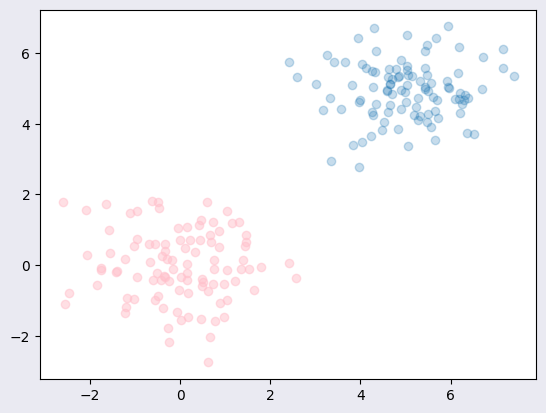

In [8]:
import numpy as np

#Example dataset
N_samples_per_class = 100
d_dimensions = 2
x = np.vstack((np.random.randn(N_samples_per_class, d_dimensions),
               np.random.randn(N_samples_per_class, d_dimensions)
               +np.array([5,5])))
y = np.concatenate([-1.0*np.ones(N_samples_per_class),
              1.*np.ones(N_samples_per_class)])

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
fig.set_facecolor('#EAEAF2')
idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.25)
idx = y==-1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.5,color='pink')

In [9]:
import autograd.numpy as np
from autograd import grad

def SVM_predictions(w, inputs):
    return np.dot(w[0,:-1],inputs.T)+w[0,-1]

def SVM_training_loss(weights, inputs, targets):
    pred = SVM_predictions(weights, inputs)
    return np.sum((targets-pred)**2)/inputs.shape[0]

def optimize(inputs, targets, training_loss):
    gradient_loss = grad(training_loss)
    weights = np.zeros((1,inputs.shape[1]+1))
    print("Initial loss:", training_loss(weights, inputs, targets))
    for i in range(100000):
        weights -= gradient_loss(weights, inputs, targets) * 0.001
        if i%10000 == 0:
            print(" Loss:", training_loss(weights, inputs, targets))
    print("Final loss:", training_loss(weights, inputs, targets))
    return weights

weights = optimize(x, y, SVM_training_loss)
print("Weights", weights)

Initial loss: 1.0
 Loss: 0.9512490394947918
 Loss: 0.06807940523406797
 Loss: 0.06807940465336586
 Loss: 0.06807940465336584
 Loss: 0.06807940465336584
 Loss: 0.06807940465336584
 Loss: 0.06807940465336584
 Loss: 0.06807940465336584
 Loss: 0.06807940465336584
 Loss: 0.06807940465336584
Final loss: 0.06807940465336584
Weights [[ 0.16229204  0.21086482 -0.92203745]]


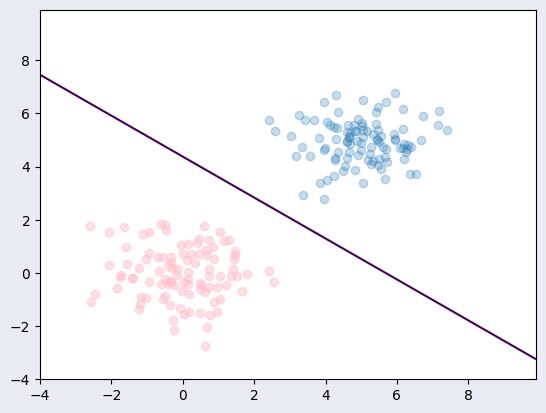

In [10]:
delta = 0.1
xx = np.arange(-4.0, 10.0, delta)
yy = np.arange(-4.0, 10.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
test_data = np.concatenate([Xf[:,np.newaxis],Yf[:,np.newaxis]],axis=1)
Z = SVM_predictions(weights,test_data)

fig, ax = plt.subplots(1, 1)
fig.set_facecolor('#EAEAF2')
Z = np.reshape(Z,(xx.shape[0],xx.shape[0]))
plt.contour(XX,YY,Z,[0])
idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.25)
idx = y==-1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.5,color='pink')

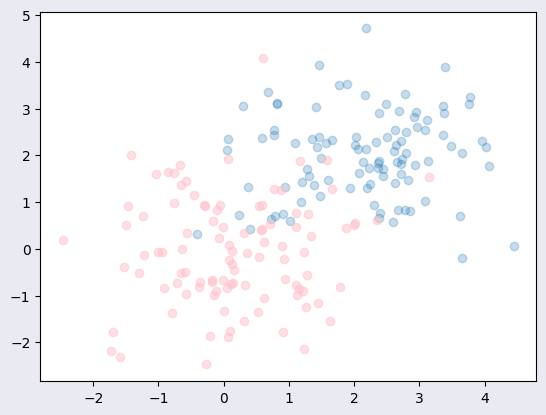

In [11]:
import numpy as np

#Example dataset
N_samples_per_class = 100
d_dimensions = 2
x = np.vstack((np.random.randn(N_samples_per_class, d_dimensions),
               np.random.randn(N_samples_per_class, d_dimensions)
               +np.array([2,2])))
y = np.concatenate([-1.0*np.ones(N_samples_per_class),
              1.*np.ones(N_samples_per_class)])

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
fig.set_facecolor('#EAEAF2')
idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.25)
idx = y==-1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.5,color='pink')

In [12]:
# solution code


import autograd.numpy as np
from autograd import grad

def SVM_predictions(w, inputs):
    return np.dot(w[0,:-1],inputs.T)+w[0,-1]

def SVM_training_loss(weights, inputs, targets):
    pred = SVM_predictions(weights, inputs)
    return np.sum(np.maximum(0,1-targets*pred))/inputs.shape[0]

def optimize(inputs, targets, training_loss):
    gradient_loss = grad(training_loss)
    weights = np.array([[1.15196035, 1.06797815, -2.0131]])
    print("Initial loss:", training_loss(weights, inputs, targets))
    for i in range(10000):
        weights -= gradient_loss(weights, inputs, targets) * 0.01
        if i%1000 == 0:
            print(" Loss:", training_loss(weights, inputs, targets))
    print("Final loss:", training_loss(weights, inputs, targets))
    return weights

weights = optimize(x, y, SVM_training_loss)
print("Weights", weights)

Initial loss: 0.2486325506431502
 Loss: 0.24847982402922614
 Loss: 0.22968090511371828
 Loss: 0.22946794102879464
 Loss: 0.2293964898291943
 Loss: 0.22935235316548208
 Loss: 0.22933844076282234
 Loss: 0.22932395462947844
 Loss: 0.2293095045362409
 Loss: 0.22929533506607186
 Loss: 0.2292843189297235
Final loss: 0.2292844368860235
Weights [[ 0.86019976  0.97782033 -1.9123    ]]


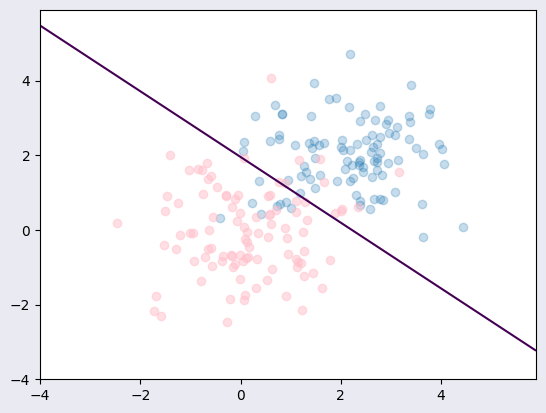

In [13]:
delta = 0.1
xx = np.arange(-4.0, 6.0, delta)
yy = np.arange(-4.0, 6.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
test_data = np.concatenate([Xf[:,np.newaxis],Yf[:,np.newaxis]],axis=1)
Z = SVM_predictions(weights,test_data)

fig, ax = plt.subplots(1, 1)
fig.set_facecolor('#EAEAF2')
Z = np.reshape(Z,(xx.shape[0],xx.shape[0]))
plt.contour(XX,YY,Z,[0])
idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.25)
idx = y==-1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.5,color='pink')

Neural Network



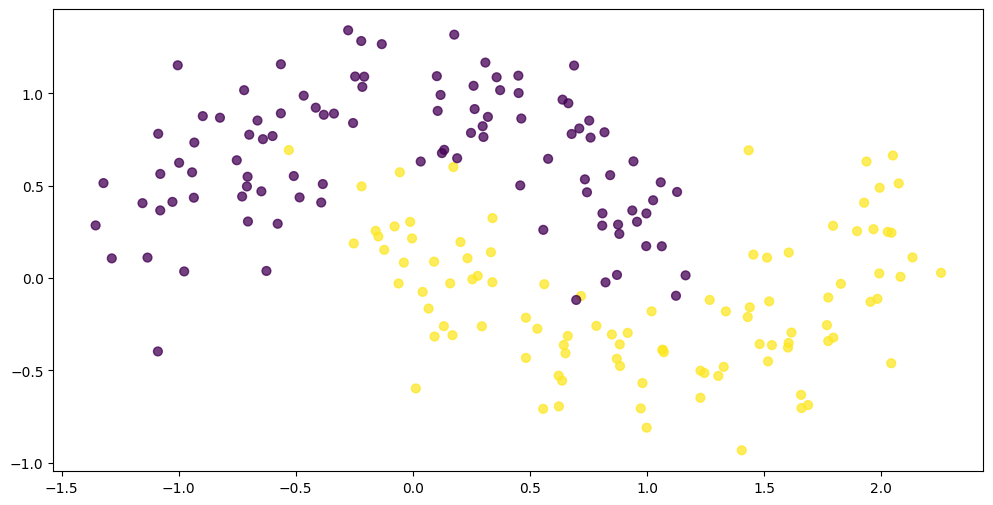

In [14]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc.flatten import flatten

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.75)

Let's now build a 3-layer neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our data, 2. Similarly, the number of nodes in the output layer is determined by the number of classes we have, also 2.

Our network makes predictions using forward propagation, which is just a bunch of matrix multiplications and the application of the activation function(s). If $x$
 is the 2-dimensional input to our network then we calculate our prediction $\hat y$. Let's now build a 3-layer neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our data, 2. 
 Similarly, the number of nodes in the output layer is determined by the number of classes we have, also 2.(also two-dimensional) as follows:

 $$ z_{1}=xw_{1}+b_{1}\\
    a_{1}=tanh(z_{1})\\
    z_{2}=a_{1}w_{2}+b_{2}\\
    a_{2}=softmax(z_{2})$$

$w_{1} $,$b_{1} $,$w_{2} $,$b_{2} $ are parameters of our network, which we need to learn from our training data. You can think of them as matrices transforming data between layers of the network. Looking at the matrix multiplications above we can figure out the dimensionality of these matrices. If we use 500 nodes for our hidden layer then $w_{1} \in  \mathbb{R}^{2\times 500} $,$b_{1} \in  \mathbb{R}^{500} $,$w_{2} \in  \mathbb{R}^{500\times 2} $,$b_{2} \in  \mathbb{R}^{2} $

A common choice with the softmax output is the cross-entropy loss. If we have $N$ training examples and $C$ classes then the loss for our prediction $\hat {y}$ with respect to the true labels is given by:

Un choix courant avec la sortie softmax est la perte d'entropie croisée. Si nous avons des exemples de formation $N$ et des classes $C$, alors la perte pour notre prédiction $\hat {y}$ par rapport aux vraies étiquettes est donnée par :

$$ L(y,\hat {y})=-\dfrac{1}{N}\sum _{n\in N} \sum_{i\in C} y_{n,i} log (\hat {y}_{n,i})$$ 



In [15]:
num_examples = len(X)     # training set size
nn_input_dim = 2          # input layer dimensionality
nn_output_dim = 2         # output layer dimensionality

# Gradient descent parameters 

epsilon = 0.01            # learning rate for gradient descent

def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation to calculate our predictions
    
    z1 = np.dot(X,W1) + b1
    a1 = np.tanh(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    return 1./num_examples * data_loss

# output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation
    
    z1 = np.dot(x,W1) + b1
    a1 = np.tanh(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

This program solves the optimization problem by using AD:

Loss after iteration 0: 0.578567
Loss after iteration 1000: 0.288832
Loss after iteration 2000: 0.233156
Loss after iteration 3000: 0.182124
Loss after iteration 4000: 0.147160
Loss after iteration 5000: 0.118781
Loss after iteration 6000: 0.100822
Loss after iteration 7000: 0.089667
Loss after iteration 8000: 0.082638
Loss after iteration 9000: 0.078198
Loss after iteration 10000: 0.075316
Loss after iteration 11000: 0.073359
Loss after iteration 12000: 0.071963
Loss after iteration 13000: 0.070921
Loss after iteration 14000: 0.070112
Loss after iteration 15000: 0.069465
Loss after iteration 16000: 0.068932
Loss after iteration 17000: 0.068485
Loss after iteration 18000: 0.068102
Loss after iteration 19000: 0.067770


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

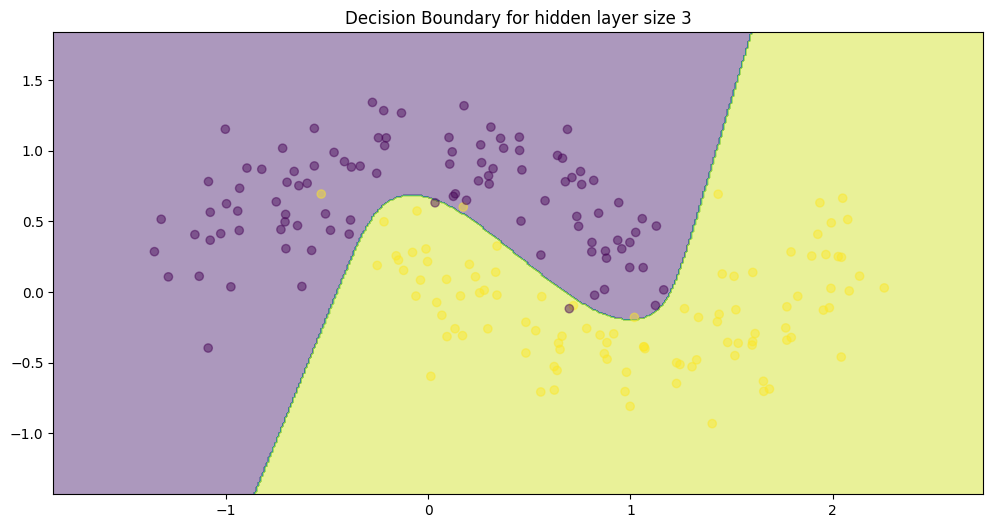

In [16]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = np.dot(X,model['W1']) + model['b1']
        a1 = np.tanh(z1)
        z2 = np.dot(a1,model['W2']) + model['b2']
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
                
        gradient_loss = grad(calculate_loss)
        
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        model_flat -= grad_flat * 0.05
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

In [30]:
pip install torch

Note: you may need to restart the kernel to use updated packages.Collecting torch
   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/203.1 MB 991.0 kB/s eta 0:03:25
   ---------------------------------------- 0.1/203.1 MB 1.4 MB/s eta 0:02:24
   ---------------------------------------- 0.2/203.1 MB 1.6 MB/s eta 0:02:11
   ---------------------------------------- 0.4/203.1 MB 2.3 MB/s eta 0:01:28
   ---------------------------------------- 0.7/203.1 MB 3.0 MB/s eta 0:01:08
   ---------------------------------------- 0.9/203.1 MB 3.5 MB/s eta 0:00:58
   ---------------------------------------- 1.2/203.1 MB 3.8 MB/s eta 0:00:54
   ---------------------------------------- 1.5/203.1 MB 3.9 MB/s eta 0:00:52
   ---------------------------------------- 1.8/203.1 MB 4.3 MB/s eta 0:00:47
   ---------------------------------------- 2.0/203.1 MB 4.3 MB/s eta 0:00:47
   ---------------------------------------- 2.2/203.1 MB 4.3 MB/s

DEPRECATION: Loading egg at c:\users\hp\desktop\anaconda\lib\site-packages\dgfraud_tf2-0.0.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
 
torch.set_default_dtype(torch.double)
# Uncomment this to run on GPU:
# torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [32]:
def f(x, a):
    return torch.cos(a*x**3 - 2*x**2 - 4*x)

In [33]:
t = torch.linspace(-2.2, 3.5, 50)
t

tensor([-2.2000, -2.0837, -1.9673, -1.8510, -1.7347, -1.6184, -1.5020, -1.3857,
        -1.2694, -1.1531, -1.0367, -0.9204, -0.8041, -0.6878, -0.5714, -0.4551,
        -0.3388, -0.2224, -0.1061,  0.0102,  0.1265,  0.2429,  0.3592,  0.4755,
         0.5918,  0.7082,  0.8245,  0.9408,  1.0571,  1.1735,  1.2898,  1.4061,
         1.5224,  1.6388,  1.7551,  1.8714,  1.9878,  2.1041,  2.2204,  2.3367,
         2.4531,  2.5694,  2.6857,  2.8020,  2.9184,  3.0347,  3.1510,  3.2673,
         3.3837,  3.5000])

In [34]:
# variables used for gradient evaluation are created with requires_grad=True
x = torch.zeros(1, requires_grad=True)
 
# gradients again need to be evaluated 
df = np.zeros(t.shape)
for i in range(len(t)):
    # set the value of the input variable without changing its gradient
    # via .data attribute
    x.data = t[i]
    v = f(x, 1.0)
    # .backward() on function output computes gradients
    v.backward()
    # access gradients via .grad attribute
    df[i] = x.grad
    # gradient needs to be reset before computing the next value
    x.grad.zero_()
 
# Numpy arrays needed for plotting can be accessed via .numpy()

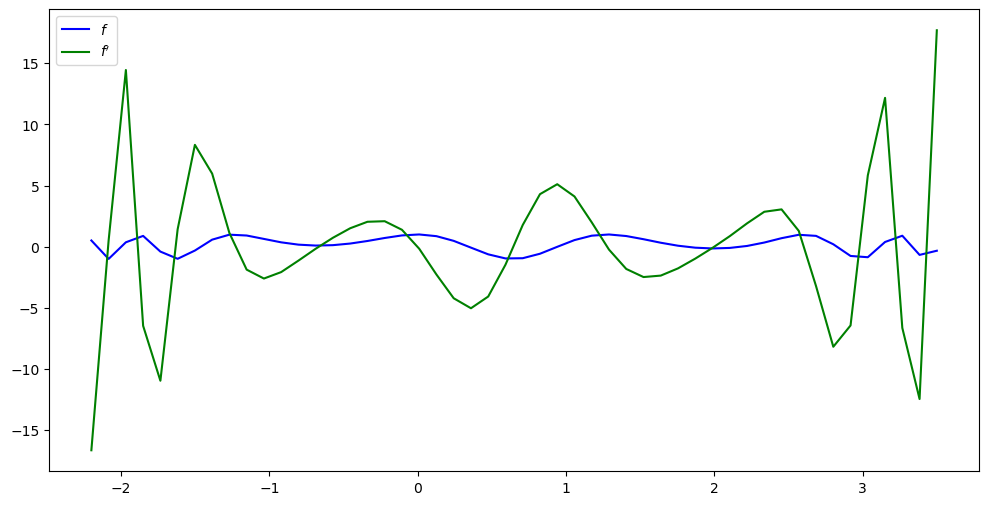

In [35]:
plt.plot(t.numpy(), f(t, 1.0).numpy(), color='b', label=r'$f$')
plt.plot(t.numpy(), df, color='g', label=r"$f'$")
plt.legend()
plt.show()

Automatic differentiation is not numerical differentiation.

Numerical differentiation refers to a class of methods that computes derivatives through finite difference formulae based on the definition of the derivative,

$$\dfrac{df}{dx}(x)\simeq \dfrac {f(x+h)-f(x)}{h}$$

Such methods are limited in precision due to truncation and roundoff errors because accuracy depends on choosing an appropriate step size h. Let’s consider a basic example.

Errors in The Finite Difference Method

Let’s consider the function $ f(x)=x-exp(-2sin^{2}(4x))$. Using our basic differentiation rules, we can compute the derivative symbolically,
$$\dfrac{df}{dx}(x) = 1+16\,sin(4x) cos(4x) exp(-2sin^{2}(4x))$$

Let’s write some code to calculate derivatives using the finite difference method for this function.

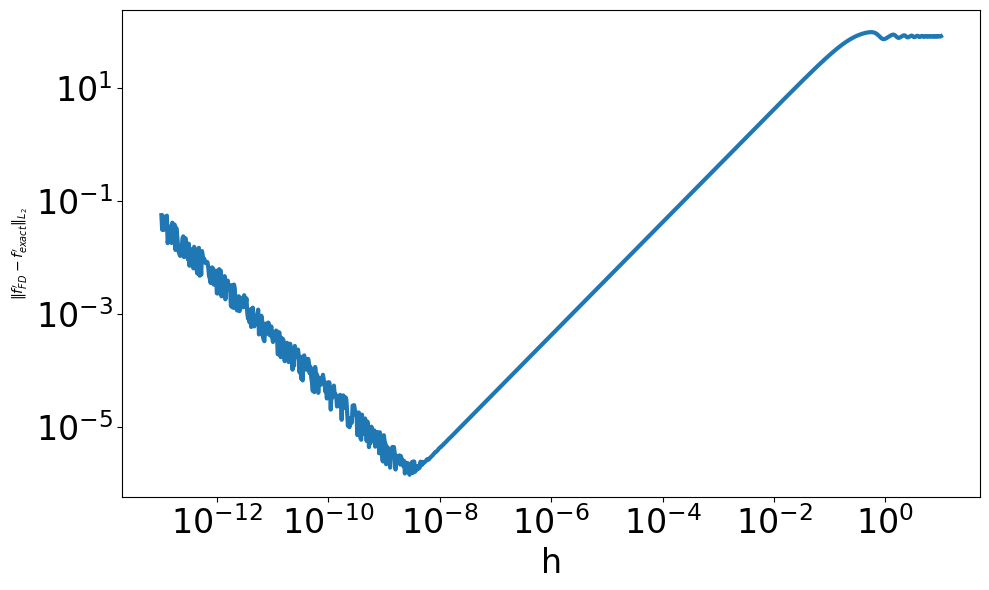

In [36]:
#define our function
def f(x):
    return x-np.exp(-2*np.sin(4*x)**2)

#explicitly define the derivative to compare accuracy
def dfdx(x):
    return 1+16*np.exp(-2*np.sin(4*x)**2)*np.sin(4*x)*np.cos(4*x)

#get numerical derivative at x for stepsize h
def finite_diff(f, x, h):
    return (f(x+h)-f(x))/h

#explore accuracy when changing h
x = np.linspace(0, 2, 1000)
hs = np.logspace(-13, 1, 1000)

errs = np.zeros(len(hs))
for i, h in enumerate(hs):
    err = finite_diff(f, x, h)-dfdx(x) # compute error at each domain point
    errs[i] = np.linalg.norm(err) # store L2 norm of error

#make plot of the error
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(hs, errs, lw=3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('h', fontsize=24)
ax.set_ylabel(r'$\|f^{\prime}_{FD}-f^{\prime}_{exact}\|_{L_2}$')
ax.tick_params(labelsize=24)
plt.tight_layout()

In [37]:
import pandas as pd
from sklearn import datasets
#from skelearn.metrics import accuracy_score, confusion_matrix


In [38]:
import numpy as np
#charger l'ensemble de données Iris
iris=datasets.load_iris()
X=iris.data
y=iris.target
#Explorer les données
df=pd.DataFrame(data=np.c_[iris['data'],iris['target']],columns=iris['feature_names']+['target'])
print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  


In [ ]:
import autograd.numpy as 

*
from autograd import grad

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logistic_predictions(weights, inputs):
    return sigmoid(np.dot(inputs, weights))

def training_loss(weights, inputs, targets):
    preds = logistic_predictions(weights, inputs)
    loss = preds * targets + (1 - preds) * (1 - targets)
    return -np.sum(np.log(loss))

def optimize(inputs, targets, training_loss):
    # Optimize weights using gradient descent.
    gradient_loss = grad(training_loss)
    weights = np.zeros(inputs.shape[1])
    print("Initial loss:", training_loss(weights, inputs, targets))
    for i in range(100):
        weights -= gradient_loss(weights, inputs, targets) * 0.01
    print("Final loss:", training_loss(weights, inputs, targets))
    return weights

# Build a toy dataset with 3d data
inputs = np.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])
targets = np.array([True, True, False, True])

weights = optimize(inputs, targets, training_loss)
print("Weights:", weights)

In [41]:
import autograd.numpy as np  # Use autograd for gradient calculations
from autograd import grad
from sklearn import datasets
import pandas as pd

# Sigmoid function for logistic regression
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Logistic predictions using weights
def logistic_predictions(weights, inputs):
    return sigmoid(np.dot(inputs, weights))

# Training loss for logistic regression
def training_loss(weights, inputs, targets):
    preds = logistic_predictions(weights, inputs)
    # Compute binary cross-entropy loss
    loss = -np.sum(targets * np.log(preds) + (1 - targets) * np.log(1 - preds))
    return loss

# Gradient descent optimizer
def optimize(inputs, targets, training_loss):
    # Use autograd to compute the gradient of the loss
    gradient_loss = grad(training_loss)
    # Initialize weights to zeros
    weights = np.zeros(inputs.shape[1])
    print("Initial loss:", training_loss(weights, inputs, targets))
    
    learning_rate = 0.01  # Step size for gradient descent
    for i in range(100):  # Perform 100 iterations of gradient descent
        # Update weights based on gradient
        weights -= gradient_loss(weights, inputs, targets) * learning_rate
    
    print("Final loss:", training_loss(weights, inputs, targets))
    return weights

# Load the Iris dataset
iris = datasets.load_iris()

# Separate features and labels
X = iris.data  # Features (4-dimensional)
y = iris.target  # Labels (0, 1, 2)

# Create a DataFrame for better visualization
df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                  columns=iris['feature_names'] + ['target'])
print("Aperçu des données Iris :")
print(df.head())

# Reduce the dataset to simulate the "toy dataset"
inputs = X[:4, :3]  # Select the first 4 rows and first 3 columns
targets = (y[:4] == 0)  # Create binary labels (True/False)

# Optimize weights using the gradient descent optimizer
weights = optimize(inputs, targets, training_loss)

# Display final results
print("\nDonnées modifiées pour le toy dataset :")
print("Inputs:\n", inputs)
print("Targets:\n", targets)
print("Weights:", weights)


Aperçu des données Iris :
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
Initial loss: 2.772588722239781
Final loss: 0.028560943965803942

Données modifiées pour le toy dataset :
Inputs:
 [[5.1 3.5 1.4]
 [4.9 3.  1.4]
 [4.7 3.2 1.3]
 [4.6 3.1 1.5]]
Targets:
 [ True  True  True  True]
Weights: [0.67392026 0.44655145 0.19626487]


In [42]:
import autograd.numpy as np  # Use autograd for gradient calculations
from autograd import grad
from sklearn import datasets
import pandas as pd

# Sigmoid function for logistic regression
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Logistic predictions using weights
def logistic_predictions(weights, inputs):
    return sigmoid(np.dot(inputs, weights))

# Training loss for logistic regression
def training_loss(weights, inputs, targets):
    preds = logistic_predictions(weights, inputs)
    # Compute binary cross-entropy loss
    loss = -np.sum(targets * np.log(preds) + (1 - targets) * np.log(1 - preds))
    return loss

# Gradient descent optimizer
def optimize(inputs, targets, training_loss):
    # Use autograd to compute the gradient of the loss
    gradient_loss = grad(training_loss)
    # Initialize weights to zeros
    weights = np.zeros(inputs.shape[1])
    print("Initial loss:", training_loss(weights, inputs, targets))
    
    learning_rate = 0.01  # Step size for gradient descent
    for i in range(100):  # Perform 100 iterations of gradient descent
        # Update weights based on gradient
        weights -= gradient_loss(weights, inputs, targets) * learning_rate
    
    print("Final loss:", training_loss(weights, inputs, targets))
    return weights

# Load the Iris dataset
iris = datasets.load_iris()

# Separate features and labels
X = iris.data  # Features (4-dimensional)
y = iris.target  # Labels (0, 1, 2)

# Create a DataFrame for better visualization
df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                  columns=iris['feature_names'] + ['target'])
print("Aperçu des données Iris :")
print(df.head())

# Binary classification: keep only two classes (0 and 1) for simplicity
# Filter rows where target is 0 or 1
binary_filter = (y == 0) | (y == 1)
inputs = X[binary_filter]  # Select features for classes 0 and 1
targets = (y[binary_filter] == 1).astype(float)  # Convert class 1 to 1.0 and class 0 to 0.0

# Optimize weights using the gradient descent optimizer
weights = optimize(inputs, targets, training_loss)

# Display final results
print("\nDonnées modifiées pour le dataset Iris :")
print("Inputs (first 5 rows):\n", inputs[:5])
print("Targets (first 5 rows):\n", targets[:5])
print("Weights:\n", weights)


Aperçu des données Iris :
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
Initial loss: 69.31471805599453
Final loss: 0.41577571071610264

Données modifiées pour le dataset Iris :
Inputs (first 5 rows):
 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
Targets (first 5 rows):
 [0. 0. 0. 0. 0.]
Weights:
 [-0.67027239 -2.36766525  3.53924409  1.51748666]
